In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pprint
import copy
import matplotlib.pyplot as plt
import itertools

# Load datasets

In [25]:
# Load and treat vocab
with open('vocab.txt') as file:
    vocab = file.readlines()
    vocab = [line.rstrip() for line in vocab]

vocab_size = len(vocab)
print('There are %d unique words in our dataset.' % vocab_size)

# Hash table for words to indices and viceversa
word_to_ix = { w:i for i,w in enumerate(vocab) }
ix_to_word = { i:w for i,w in enumerate(vocab) }

There are 20500 unique words in our dataset.


In [26]:
vocab

['',
 '00',
 '0000',
 '000000',
 '001',
 '004',
 '008',
 '01',
 '010',
 '01087',
 '011',
 '012',
 '016',
 '01745',
 '01918',
 '02',
 '020',
 '0201',
 '0208',
 '03',
 '032',
 '04',
 '040',
 '05',
 '052',
 '055',
 '056',
 '057',
 '06',
 '07',
 '0710',
 '0725',
 '08',
 '080',
 '081',
 '09',
 '10',
 '100',
 '1000',
 '10000',
 '10006',
 '10007',
 '10029',
 '10079',
 '10081',
 '101',
 '1010',
 '102',
 '1024',
 '103',
 '1035',
 '104',
 '105',
 '106',
 '107',
 '108',
 '1082',
 '109',
 '11',
 '110',
 '1100',
 '111',
 '1110',
 '112',
 '1123',
 '113',
 '114',
 '115',
 '116',
 '117',
 '1179',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '1250',
 '1251',
 '1252',
 '126',
 '127',
 '128',
 '1282',
 '1284',
 '1285',
 '1288',
 '1291',
 '1296',
 '13',
 '1301',
 '1304',
 '1305',
 '1307',
 '131',
 '1311',
 '1314',
 '1317',
 '132',
 '1320',
 '133',
 '134',
 '137',
 '1370',
 '1377',
 '1394',
 '1395',
 '14',
 '141',
 '142',
 '1423',
 '14443',
 '145',
 '148',
 '1496',
 '15',
 '1500'

In [27]:
# Load training set. 
dfs = pd.read_csv('ordered-labels-dataset-subsample.txt', delim_whitespace=True, index_col = 0, header = None, engine='python') #keep_default_na = False, Keep 'null' as valid value.

# Build set with lists
dfs['Words'] = dfs.dropna()[2].apply(lambda x: x.split('_'))
# Build input for transformer: add space and end of line
dfs['Names'] = dfs.dropna()['Words'].apply(lambda x: str(' ' + ' '.join(x) + ' \n'))
words_lists = list(dfs.loc[:,'Words'])

In [28]:
df_names = dfs['Names'].dropna()

In [29]:
df_names

0
32977             dpkg set prog name \n
32978              get int attribute \n
32979                  finalize test \n
32980                  run psm shell \n
32981      erlang backings tore grow \n
                      ...              
329784                         sr dt \n
329785             chirp client link \n
329786           cgr preview forward \n
329787            game set color num \n
329788            mdns ec dns packet \n
Name: Names, Length: 296744, dtype: object

In [30]:
df_names.to_csv('names.csv',index=False)

In [31]:
# Get stats regarding len of names
dfs['Name_length'] = dfs['Words'].dropna().apply(lambda x: len(x))

dfs['Name_length'].describe()

count    296744.000000
mean          3.656994
std           1.577809
min           1.000000
25%           3.000000
50%           3.000000
75%           5.000000
max          17.000000
Name: Name_length, dtype: float64

# Split train and test. Build probability matrix

In [32]:
# Split in train and test set
X_train, X_test = train_test_split(words_lists, test_size=0.1, random_state=42)

In [33]:
# Number of positions observed
Tx = int(max(dfs['Name_length']))
print('Maximum length of names:', Tx)

# Matrix counting word appearances, row for position, columns for each word (among 20500 words)
word_freq = np.zeros((Tx+1,vocab_size), dtype=np.int32)

for i in range(Tx):
    for word_list in X_train:
        if isinstance(word_list,list) and len(word_list) > i:
            word_freq[i,word_to_ix[word_list[i]] ] += 1

# Last row: sum of appearances of each word
for j in range(vocab_size):
    word_freq[Tx,j] = sum(word_freq[:,j])
            
word_freq

Maximum length of names: 17


array([[ 0,  8,  0, ...,  1,  1,  0],
       [ 0, 53,  0, ...,  0,  0,  1],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 68,  2, ...,  1,  1,  2]])

In [34]:
# Words not appearing in training set:
sum(word_freq[Tx,:] == 0)

1561

In [35]:
word_freq_normalized = word_freq[:Tx,:].astype(np.float32)

# Normalize
for j in range(vocab_size):
    if sum(word_freq_normalized[:,j]) != 0:
        word_freq_normalized[:,j] /= sum(word_freq_normalized[:Tx,j])

In [36]:
# Summary of obtained matrices
print(np.shape(word_freq))
print(word_freq[:18,:20])

(18, 20500)
[[ 0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 53  0  0  9  0  0  3  0  0  0  2  0  0  0  1  0  3  0  0]
 [ 0  0  1  2  0  1  0  2  0  0  0  0  0  1  1  5  0  0  0  1]
 [ 0  4  1  1  0  0  1  4  2  0  1  0  0  0  0 16  1  0  1  1]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [37]:
print(np.shape(word_freq_normalized))
print(word_freq_normalized[:18,:5])

(17, 20500)
[[0.         0.11764706 0.         0.         0.        ]
 [0.         0.7794118  0.         0.         1.        ]
 [0.         0.         0.5        0.6666667  0.        ]
 [0.         0.05882353 0.5        0.33333334 0.        ]
 [0.         0.02941176 0.         0.         0.        ]
 [0.         0.01470588 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


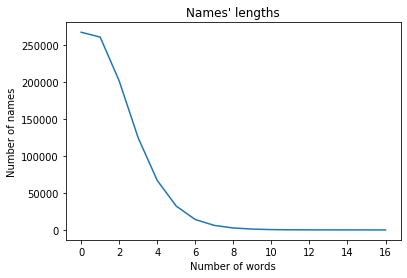

In [38]:
# Plot showing names' length
plt.plot([sum(word_freq[x,:]) for x in range(17)])
plt.title('Names\' lengths')
plt.ylabel('Number of names')
plt.xlabel('Number of words')
plt.show()

# Model (old)

In [39]:
def obtain_probabilities(word_list):
    permutations = list(itertools.permutations(word_list, len(word_list)))
    print(permutations)
    probs = np.zeros(len(permutations))
    for ix, permutation in enumerate(permutations):
        prob_tmp = 1
        for i in range(len(permutation)):
            prob_tmp *= word_freq_normalized[ i, word_to_ix[permutation[i]] ]
            print(word_freq_normalized[ :, word_to_ix[permutation[i]] ])
        probs[ix] = prob_tmp
    
    return probs

In [40]:
obtain_probabilities(['gdalget','gdu'])

[('gdalget', 'gdu'), ('gdu', 'gdalget')]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.9655172  0.03448276 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0.9655172  0.03448276 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0.03448276, 0.        ])

# Extend GPT2 vocabulary

In [41]:
# Useful links for treating vocab:
# https://discuss.huggingface.co/t/roberta-from-scratch-with-different-vocab-vs-fine-tuning/569
# https://medium.com/@pierre_guillou/nlp-how-to-add-a-domain-specific-vocabulary-new-tokens-to-a-subword-tokenizer-already-trained-33ab15613a41

In [42]:
# Choose DistilGPT2: GPT2 lighter version
model_checkpoint = "distilgpt2"

In [43]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) #vocab_file = 'vocab.txt' ??

In [44]:
# should I use the following vocab set ?
# vocab_with_symbol = ['Ġ' + word for word in vocab]

In [45]:
tokenizer.get_vocab()

{'ĠCS': 9429,
 'ĠThumbnails': 28924,
 'ghan': 6064,
 'porting': 26527,
 'ĠLatter': 34437,
 'ĠLore': 15639,
 'ĠTerritories': 42354,
 'Ġpertinent': 35268,
 'Ġtechnology': 3037,
 'Ġcrus': 25164,
 'Ġcalcium': 19700,
 'majority': 35839,
 'ĠEval': 26439,
 'Ġfaux': 36748,
 'Ġagric': 8986,
 'Ġcook': 4255,
 'Ġdefinitive': 17347,
 'Gallery': 29352,
 'Enable': 36695,
 'Ġantidepressant': 41897,
 'ĠEuropeans': 20006,
 'Ġrepent': 28787,
 'Ġsweating': 38912,
 '################': 14468,
 'Ġsmokers': 24109,
 'Ġunamb': 42053,
 'oooo': 13321,
 'ĠErrors': 44225,
 'ĠDresden': 46993,
 '================': 4770,
 'Zip': 41729,
 'Ġacc': 697,
 'lights': 8091,
 'Probably': 34784,
 'ĠUn': 791,
 'ĠObserver': 27058,
 'ĠPreferences': 49780,
 'psons': 31410,
 'Ġunborn': 36172,
 'Ġrain': 6290,
 'Ġmotorcycles': 39404,
 'ĠABV': 49993,
 'akia': 21897,
 'ĠPale': 21706,
 'Ġarsen': 38924,
 'obil': 25898,
 'Ġcontradicts': 40081,
 'Ġexemplary': 40690,
 'Ġnon': 1729,
 'Ġexcept': 2845,
 'Ġhyper': 8718,
 'Ġfucking': 9372,
 'ble'

In [46]:
gpt_vocab = set(tokenizer.get_vocab().keys())

print('GPT2 has a vocab of %d words, the provided vocab has %d words, and there are %d words in their intersection.' 
      %(len(gpt_vocab), len(vocab), len(set(vocab).intersection(gpt_vocab))))

GPT2 has a vocab of 50257 words, the provided vocab has 20500 words, and there are 3871 words in their intersection.


In [47]:
'''# Increase the vocabulary

num_added_toks = tokenizer.add_tokens(vocab_with_symbol)

print('We have added', num_added_toks, 'tokens. New vocab size: ', len(set(tokenizer.get_vocab().keys())))

# Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.

model.resize_token_embeddings(len(tokenizer))
'''

"# Increase the vocabulary\n\nnum_added_toks = tokenizer.add_tokens(vocab_with_symbol)\n\nprint('We have added', num_added_toks, 'tokens. New vocab size: ', len(set(tokenizer.get_vocab().keys())))\n\n# Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.\n\nmodel.resize_token_embeddings(len(tokenizer))\n"

In [48]:
tokenizer.tokenize('dpkg set prog name')

['dp', 'kg', 'Ġset', 'Ġprog', 'Ġname']

# Pre process training set

In [49]:
# Load names in a transformer format
import transformers
from datasets import load_dataset
dataset_dict = load_dataset('csv', data_files='names.csv')
dataset = dataset_dict['train']
dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=42)

Using custom data configuration default-9d82746b4bd06c73


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:\Users\SP003DA2\.cache\huggingface\datasets\csv\default-9d82746b4bd06c73\0.0.0\51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Names'],
        num_rows: 281906
    })
    test: Dataset({
        features: ['Names'],
        num_rows: 14838
    })
})

In [51]:
dataset['train'][2]

{'Names': ' secs \n'}

In [52]:
def tokenize_function(examples):
    return tokenizer(examples["Names"])

In [53]:
# Tokenize inputs
tokenized_dataset = dataset.map(
    tokenize_function, batched=True, remove_columns=["Names"])

  0%|          | 0/282 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [54]:
tokenized_dataset["train"][1]

{'input_ids': [5412, 900, 3298, 13536, 220, 198],
 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [55]:
tokenizer.decode(tokenized_dataset["train"][1]['input_ids'])

' handle set global enables \n'

In [56]:
tokenizer.convert_ids_to_tokens(11688)

'Ġattribute'

In [57]:
# block_size = tokenizer.model_max_length
block_size = 32

In [58]:
# Concatenate inputs
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # Drop the small remainder
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [59]:
lm_dataset = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=1000,
#    num_proc=4,
)

  0%|          | 0/282 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [60]:
lm_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 56369
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2957
    })
})

In [61]:
# Inputs changed:
tokenizer.decode(lm_dataset["train"][1]["input_ids"])

' test incremental no break \n rl reap \n check name \n login manager skeleton get controllers \n mcd null able variant equal \n put h'

# Initialize and fine-tune GPT2

In [62]:
from transformers import TFAutoModelForCausalLM

model = TFAutoModelForCausalLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [63]:
from transformers import create_optimizer, AdamWeightDecay

In [64]:
optimizer = AdamWeightDecay(lr=2e-5, weight_decay_rate=0.01)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [65]:
import tensorflow as tf

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [66]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

train_set = lm_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

test_set = lm_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [67]:
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard

model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-wikitext2"

tensorboard_callback = TensorBoard(log_dir="./clm_model_save/logs")

#push_to_hub_callback = PushToHubCallback(
#    output_dir="./clm_model_save",
#    tokenizer=tokenizer,
#    hub_model_id=push_to_hub_model_id,
#)

callbacks = [tensorboard_callback]#, push_to_hub_callback]

model.fit(train_set, validation_data=test_set, epochs=3, callbacks=callbacks)

Epoch 1/3
3524/3524 [==============================] - 13831s 4s/step - loss: 4.3229 - val_loss: 3.9821
Epoch 2/3
3524/3524 [==============================] - 13900s 4s/step - loss: 3.9294 - val_loss: 3.7956
Epoch 3/3
3524/3524 [==============================] - 13650s 4s/step - loss: 3.7740 - val_loss: 3.6951


In [77]:
model.save_pretrained('FineTuned_GPT2_TF')

In [78]:
export OPENAI_GPT2_CHECKPOINT_PATH='FineTuned_GPT2_TF'

transformers-cli convert --model_type gpt2 --tf_checkpoint $OPENAI_GPT2_CHECKPOINT_PATH --pytorch_dump_output $PYTORCH_DUMP_OUTPUT [--config OPENAI_GPT2_CONFIG] [--finetuning_task_name OPENAI_GPT2_FINETUNED_TASK]

SyntaxError: invalid syntax (<ipython-input-78-7146d0bffb59>, line 1)

# Load TF model

In [79]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("./FineTuned_GPT2_TF", from_tf=True) 

All TF 2.0 model weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


# Generate names

In [ ]:
# check here:
# https://discuss.huggingface.co/t/prohibit-gpt-2-from-generating-some-words-on-a-condition/4823
# https://discuss.huggingface.co/t/example-of-prefix-allowed-tokens-fn-while-text-generation/6635
# https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate
# and look for: prefix_allowed_tokens_fn

In [68]:
tokenizer.tokenize('dpkg set prog name')

['dp', 'kg', 'Ġset', 'Ġprog', 'Ġname']

In [70]:
outputs = model.generate()  # do greedy decoding
print(f"Generated: {tokenizer.decode(outputs[0], skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Generated:  
 caml lwt unix get type 
 caml lwt unix get


In [ ]:
tokenizer.decode(outputs[2])

In [71]:
prompt = "The dog"
input_ids = tokenizer.encode(prompt, return_tensors="tf")

outputs = model.generate(
    input_ids=input_ids, max_length=40, temperature=0.7, num_return_sequences=3, do_sample=True
)

for i in range(3):  #  3 output sequences were generated
    print(f"Generated {i}: {tokenizer.decode(outputs[i], skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Generated 0: The dog 
 gtk file chooser get type 
 org gnome session manager call register client sync 
 bamf match er get extension 
 gf dbus screenshot proxy new
Generated 1: The dog 
 on read 
 add to list 
 snd mixer elem get volume 
 caml oasis license find 
 test initialize stress cb 
 get value 
Generated 2: The dog 
 read file 
 gsm exported client skeleton finalize 
 caml unit logger 
 str ncpy 
 cb get property 
 uwf to ple


In [72]:
prompt = 'dpkg set prog name'
input_ids = tokenizer.encode(prompt, return_tensors="tf")

outputs = model.generate(
    input_ids=input_ids, temperature=0.7, num_return_sequences=3, do_sample=True
)

for i in range(3):  #  3 output sequences were generated
    print(f"Generated {i}: {tokenizer.decode(outputs[i], skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Generated 0: dpkg set prog name 
 xfpm power management call get idle time 
 caml
Generated 1: dpkg set prog name 
 xdp impl account skeleton handle set property 
 cdw cd
Generated 2: dpkg set prog name 
 xdp impl account skeleton get version 
 caml exp lib


In [73]:
prompt = 'dpkg set prog name'
input_ids = tokenizer.encode(prompt, return_tensors="tf")

force_words = 'functional'
force_words_ids = tokenizer.encode(force_words, return_tensors="tf")

outputs = model.generate(
    input_ids=input_ids,
    force_words_ids=force_words_ids,
    temperature=0.7, 
    num_return_sequences=3,
    do_sample=True
)

for i in range(3):  #  3 output sequences were generated
    print(f"Generated {i}: {tokenizer.decode(outputs[i], skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Generated 0: dpkg set prog name 
 games plugin page constructor 
 ntfs fuse open dir 
Generated 1: dpkg set prog name 
 do move 
 caml oasis features make fun 

Generated 2: dpkg set prog name 
 dl get 
 lzma decode 
 wix


In [ ]:
#outputs = model.generate(input_ids, do_sample=True, max_length=len(input_ids[0])+1, num_return_sequences=2, output_scores=True)
#tokenizer.batch_decode(outputs[0], skip_special_tokens=True)